# Exercise 2.11

This could be done more nicely, there are duplicate codes

In [1]:
import numpy as np
from scipy.special import softmax
from tqdm import tqdm
np.random.seed(0)

In [2]:
class One_arm_bandits:
    def __init__(self, n, std):
        self.n = n
        self.std = std
        self.bandits_mean = np.zeros(n)
    
    def sample(self, i):
        return self.bandits_mean[i] + np.random.standard_normal()
    
    def step(self):
        self.bandits_mean += self.std * np.random.standard_normal(self.n)
    
    def best_choice(self):
        return np.argmax(self.bandits_mean)

## Base Agent

In [3]:
class BaseAgent:
    def __init__(self, n, start_estimate, stepsize):
        self.n = n
        self.mean_estimate = np.ones(n) * start_estimate
        self.sampled =  np.zeros(n)
        self.stepsize = stepsize

    def choose_sample(self):
        pass
        
    def update_estimate(self, i, val):
        self.sampled[i] += 1
        self.mean_estimate[i] = self.mean_estimate[i] + self.stepsize(self.sampled[i]) * (val - self.mean_estimate[i])


### Step sizes

In [4]:
class const_stepsize:
    def __init__(self, val):
        self.val = val
    
    def __call__(self, n):
        return self.val

def average_stepsize(n):
    return 1/n

## $\varepsilon$-greedy

In [5]:
class EpsilonGreedyAgent(BaseAgent):
    def __init__(self, n, start_estimate, stepsize, epsilon):
        super().__init__(n, start_estimate, stepsize)
       
        self.epsilon = epsilon

    def choose_sample(self):
        if np.random.rand() > self.epsilon:
            return np.argmax(self.mean_estimate)
        else:
            return np.random.randint(0, self.n)

## UCB

In [6]:
class UCBAgent(BaseAgent):
    def __init__(self, n, start_estimate, stepsize, c):
        super().__init__(n, start_estimate, stepsize)

        self.c = c

    def choose_sample(self):
        # if there are N_t(a) = 0
        N_t_zeroes = np.nonzero(self.sampled == 0)[0]
        if N_t_zeroes.shape[0] != 0:
            return N_t_zeroes[0]
        
        t = np.sum(self.sampled)
        #argmax_a[Q_t(a) + c sqrt(ln(t) / N_t(a))]
        return np.argmax(self.mean_estimate + self.c * np.sqrt(np.log(t) / self.sampled))
        
        


## Gradient

In [7]:
class GradientAgent(BaseAgent):
    def __init__(self, n, start_estimate, stepsize, alpha):
        super().__init__(n, start_estimate, stepsize)

        self.alpha = alpha
        self.H = np.zeros(n)
 

    def choose_sample(self):
        P_a = softmax(self.H)
        return np.random.choice(np.arange(0,self.n), 1, p=P_a)[0]

    def update_estimate(self, i, val):
        super().update_estimate(i, val)
        P_a = softmax(self.H)   
        new_H_i = self.H[i] + self.alpha * (val - np.mean(self.mean_estimate)) * (1 - P_a[i])
        new_H = self.H + self.alpha * (val - np.mean(self.mean_estimate)) * (0 - P_a)

        self.H = new_H
        self.H[i] = new_H_i

In [8]:
exp_start = -7
exp_number_of = 10

agent_dict = {}
for exp in range(exp_start, exp_start+exp_number_of):
    arg = 2.0 ** exp
    agent_dict[("epsilon_greedy", exp)] = EpsilonGreedyAgent(10, 0, average_stepsize, epsilon=arg)
    agent_dict[("gradient", exp)] = GradientAgent(10, 0, average_stepsize, alpha=arg)
    agent_dict[("UCB", exp)] = UCBAgent(10, 0, const_stepsize(0.1), c=arg)
    agent_dict[("optimistic_epsilon_greedy", exp)] = EpsilonGreedyAgent(10, start_estimate=arg, stepsize=average_stepsize, epsilon=0.1)
    agent_dict[("constant_epsilon_greedy", exp)] = EpsilonGreedyAgent(10, 0, const_stepsize(0.1), epsilon=arg)


rewards = {}
correct_sample = {}
for name, agent in agent_dict.items():
    rewards[name] = []
    correct_sample[name] = []

bandits = One_arm_bandits(10, 0.01)
for i in tqdm(range(200000)):
    for name,agent in agent_dict.items():
        agent_choice = agent.choose_sample()
        reward = bandits.sample(agent_choice)
        agent.update_estimate(agent_choice, reward)

        rewards[name].append(reward)
        correct_sample[name].append(bandits.best_choice() == agent_choice)
        
    bandits.step()


100%|██████████| 200000/200000 [02:13<00:00, 1498.40it/s]


In [9]:
average_rewards = {}
correct_sample_ratio = {}
for k,v in rewards.items():
    average_rewards[k] = np.average(v[100000:])

for k,v in correct_sample.items():
    correct_sample_ratio[k] = np.average(v[:])

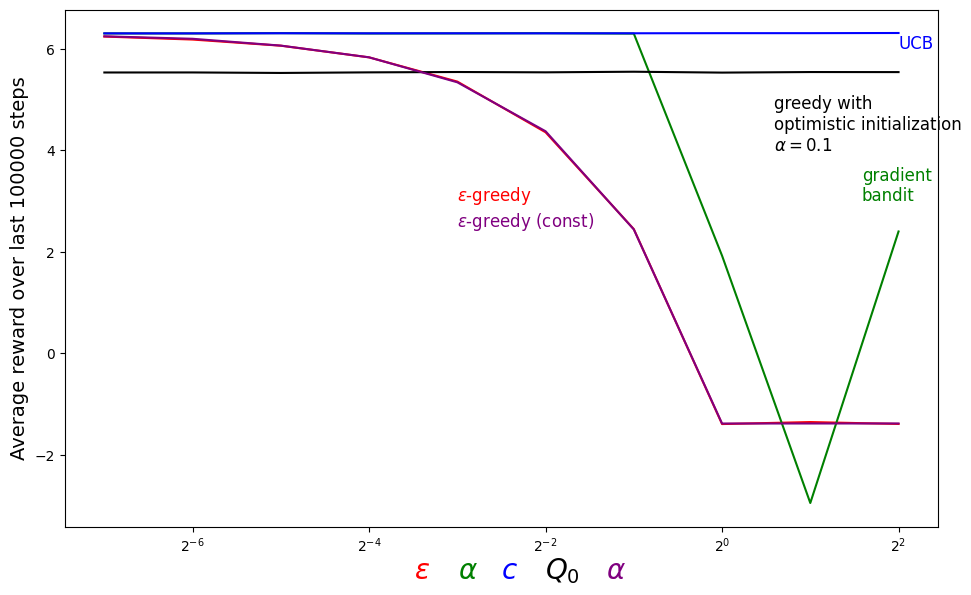

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# X-axis values (logarithmic scale from 1/128 to 4)
x = np.array([1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4])

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each curve with different colors and labels
plt.plot(x, [average_rewards[("epsilon_greedy", x)] for x in range(exp_start, exp_start+exp_number_of)], color='red', label=r'$\epsilon$-greedy')
plt.plot(x, [average_rewards[("gradient", x)] for x in range(exp_start, exp_start+exp_number_of)] , color='green', label='gradient bandit')
plt.plot(x, [average_rewards[("UCB", x)] for x in range(exp_start, exp_start+exp_number_of)] , color='blue', label='UCB')
plt.plot(x, [average_rewards[("optimistic_epsilon_greedy", x)] for x in range(exp_start, exp_start+exp_number_of)] , color='black', label=r'greedy with optimistic initialization, $\alpha=0.1$')
plt.plot(x, [average_rewards[("constant_epsilon_greedy", x)] for x in range(exp_start, exp_start+exp_number_of)] , color='purple', label=r'greedy with constant stepsize, $\epsilon=0.1$')


# Set labels and title
plt.ylabel('Average reward over last 100000 steps', fontsize=14)

# Set the x-axis to logarithmic scale
plt.xscale('log', base=2)

# Add grid
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Annotate curves for better visibility
plt.text(1/8, 3, r'$\epsilon$-greedy', color='red', fontsize=12)
plt.text(1/8, 2.5, r'$\epsilon$-greedy (const)', color='purple', fontsize=12)
plt.text(3, 3, 'gradient\nbandit', color='green', fontsize=12)
plt.text(4, 6, 'UCB', color='blue', fontsize=12)
plt.text(1.5, 4, 'greedy with\noptimistic initialization\n$\\alpha=0.1$', color='black', fontsize=12)

plt.text(0.4, -0.1, r'$\epsilon$', color='red', fontsize=20,transform=plt.gca().transAxes)
plt.text(0.45, -0.1, r'$\alpha$', color='green', fontsize=20,transform=plt.gca().transAxes)
plt.text(0.5, -0.1, r'$c$', color='blue', fontsize=20,transform=plt.gca().transAxes)
plt.text(0.55, -0.1, r'$Q_0$', color='black', fontsize=20,transform=plt.gca().transAxes)
plt.text(0.62, -0.1, r'$\alpha$', color='purple', fontsize=20,transform=plt.gca().transAxes)


# Show plot
plt.grid(False)
plt.tight_layout()
plt.savefig('../chapters_latex/figures/ex_02_11_reward.pdf')
# Display the plot
plt.show()


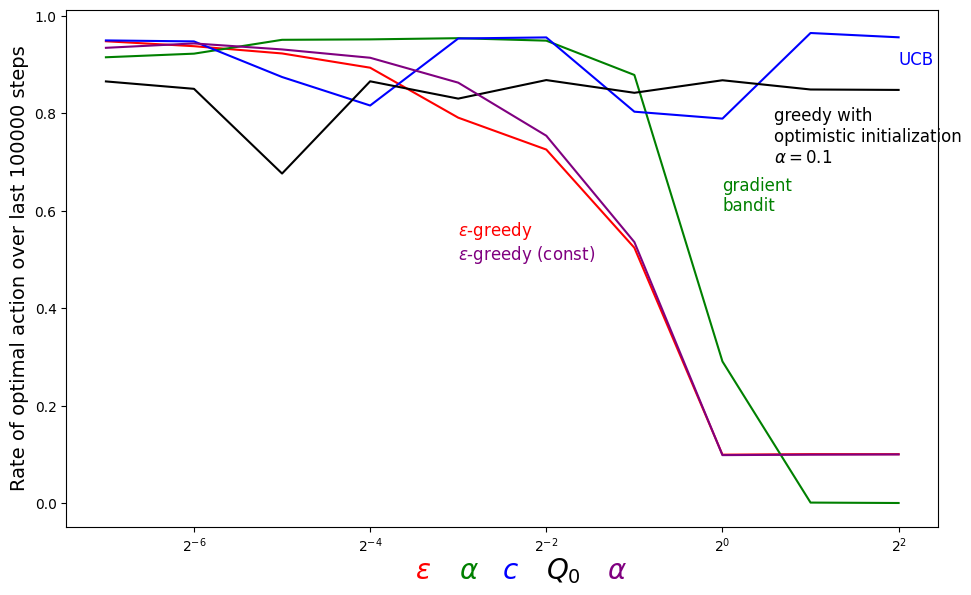

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# X-axis values (logarithmic scale from 1/128 to 4)
x = np.array([1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4])

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each curve with different colors and labels
plt.plot(x, [correct_sample_ratio[("epsilon_greedy", x)] for x in range(exp_start, exp_start+exp_number_of)], color='red', label=r'$\epsilon$-greedy')
plt.plot(x, [correct_sample_ratio[("gradient", x)] for x in range(exp_start, exp_start+exp_number_of)] , color='green', label='gradient bandit')
plt.plot(x, [correct_sample_ratio[("UCB", x)] for x in range(exp_start, exp_start+exp_number_of)] , color='blue', label='UCB')
plt.plot(x, [correct_sample_ratio[("optimistic_epsilon_greedy", x)] for x in range(exp_start, exp_start+exp_number_of)] , color='black', label=r'greedy with optimistic initialization, $\alpha=0.1$')
plt.plot(x, [correct_sample_ratio[("constant_epsilon_greedy", x)] for x in range(exp_start, exp_start+exp_number_of)] , color='purple', label=r'greedy with constant stepsize, $\epsilon=0.1$')


# Set labels and title
#plt.xlabel(r'$\epsilon \, \alpha \, c \, Q_0$', fontsize=14)
plt.ylabel('Rate of optimal action over last 100000 steps', fontsize=14)

# Set the x-axis to logarithmic scale
plt.xscale('log', base=2)

# Add grid
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.text(1/8, 0.55, r'$\epsilon$-greedy', color='red', fontsize=12)
plt.text(1/8, 0.5, r'$\epsilon$-greedy (const)', color='purple', fontsize=12)
plt.text(1, 0.6, 'gradient\nbandit', color='green', fontsize=12)
plt.text(4, 0.9, 'UCB', color='blue', fontsize=12)
plt.text(1.5, 0.7, 'greedy with\noptimistic initialization\n$\\alpha=0.1$', color='black', fontsize=12)
#
plt.text(0.4, -0.1, r'$\epsilon$', color='red', fontsize=20,transform=plt.gca().transAxes)
plt.text(0.45, -0.1, r'$\alpha$', color='green', fontsize=20,transform=plt.gca().transAxes)
plt.text(0.5, -0.1, r'$c$', color='blue', fontsize=20,transform=plt.gca().transAxes)
plt.text(0.55, -0.1, r'$Q_0$', color='black', fontsize=20,transform=plt.gca().transAxes)
plt.text(0.62, -0.1, r'$\alpha$', color='purple', fontsize=20,transform=plt.gca().transAxes)


# Show plot
plt.grid(False)
# Display the plot
plt.tight_layout()
plt.savefig('../chapters_latex/figures/ex_02_11_rate.pdf')
plt.show()
